In [1]:
import Pkg; 
Pkg.activate(".."); Pkg.instantiate();
using RxInfer, Random, Plots, StableRNGs

  Activating project at `/ws`
┌ Warning: The active manifest file is an older format with no julia version entry. Dependencies may have been resolved with a different julia version.
└ @ nothing /ws/Manifest.toml:0


In [2]:
# DATA GENERATION
# - This function should sometimes return nothing, and sometimes return a measurement a 1D position.

rng      = StableRNG(42)
position = 2.6
variance = 0.5 # Variance of measurements over position
theta    = 0.8 # Chance of measureing something 

function generate_data(x, v)
  noise = rand(rng, Normal(0, v))
  y = x + noise
end

for i in 1:10
  println(generate_data(position, variance))
end

2.2648741539427166
2.8235609212316914
3.2868153489917127
3.2547697478190543
2.663035010904655
2.9419739654982706
2.0903987737717267
2.2032435791819323
3.4873623167184085
3.248673072608817


In [3]:
datastream = Subject(Float64)
observations = labeled(Val((:y, )), combineLatest(datastream))

LabeledObservable(@NamedTuple{y::Float64}, Rocket.CombineLatestObservable{Tuple{Float64}, Tuple{Subject{Float64, AsapScheduler, AsapScheduler}}, PushEach})

In [4]:
@model function model(u, v, y)
  x ~ Normal(mean=u, variance=v)
  y ~ Normal(mean=x, variance=0.5)
end

model_autoupdates = @autoupdates begin
  u = mean(q(x))
  v = var(q(x))
end

@autoupdates begin
    u = mean(q(x))
    v = var(q(x))
end


In [12]:
imarginal = @initialization begin
  q(x) = Normal(0, 1)
  q(y) = Normal(0, 1)
end

ireturnvars = (
  x = KeepLast()
)

engine = infer(
  model           = model(),
  datastream      = observations,
  autoupdates     = model_autoupdates,
  initialization  = imarginal,
  iterations      = 10,
  keephistory    = 100,
  historyvars     = ireturnvars,
  autostart       = false,
  free_energy     = true
)

RxInferenceEngine:
  Posteriors stream    | enabled for (x)
  Free Energy stream   | enabled
  Posteriors history   | available for (x)
  Free Energy history  | available
  Enabled events       | [  ]

In [13]:
RxInfer.start(engine)

In [14]:
for i in 1:100
  data = generate_data(position, variance)
  next!(datastream, data)
end

In [15]:
RxInfer.stop(engine)

┌ Info: Saved animation to /ws/notebooks/figures/inference.gif
└ @ Plots /root/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/ws/notebooks/figures/inference.gif")
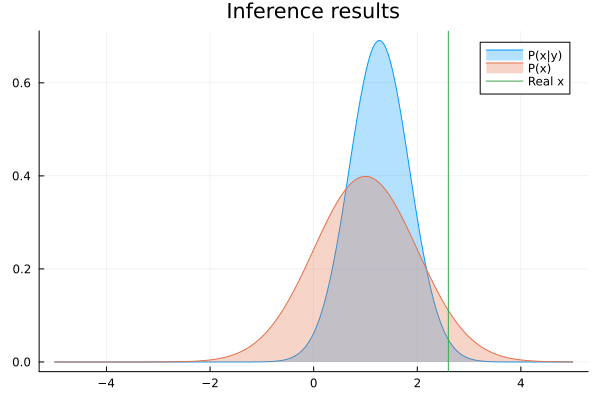

In [16]:
x_estimated = engine.history[:x]

anim = @animate for x in x_estimated
  r = range(-5, 5, length=1000)
  p = plot(title = "Inference results")
  p = plot!(r, (y)->pdf(x, y), fillalpha=0.3, fillrange=0, label="P(x|y)")
  p = plot!(r, (y)->pdf(Normal(1, 1), y), fillalpha=0.3, fillrange=0, label="P(x)")
  p = vline!([position], label="Real x")
end

gif(anim, "figures/inference.gif", fps = 5)


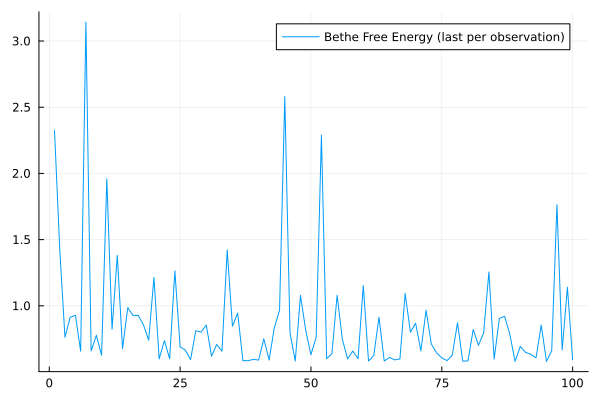

In [19]:
plot(engine.free_energy_final_only_history, label = "Bethe Free Energy (last per observation)")